In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import warnings
warnings.filterwarnings('ignore')
from IPython.display import display, clear_output
import tensorflow as tf
import tensorflow.keras.initializers as initializers
import numpy as np
import seaborn as sns; 
import imageio
import glob
import tensorflow_probability as tfp
tfd = tfp.distributions
from scipy.stats import norm, uniform, multivariate_normal, multivariate_t
from scipy.special import softmax
from sklearn.mixture import GaussianMixture
import sys
import gc

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
slim = tf.contrib.slim
from tqdm.notebook import tqdm
import sys
from scipy.linalg import block_diag
sys.path.append('../models/')
sys.path.append('../')
from ratio_utils_highdim_exp_fam import *
tf.keras.backend.set_floatx('float32')
print(tf.__version__)

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

1.15.0


In [44]:
def run_config(save_path,lrate=5e-3,steps=1500):    
    data = [tf.placeholder(tf.float32, shape=[None,n_dims]) for _ in range(K)]

    dloss = get_loss(data, bs, K, n_dims)
    optim = get_optim(dloss,lr=lrate,steps=steps,alpha=0.0)

    gt_log_ratio_p_q, gt_kl_p_q = get_gt_ratio_kl(p,q,data[0])
    kl_from_cob = get_kl_from_cob(data[0], data[1], K, n_dims)

    logit_store = [get_logits(d,K,n_dims) for d in data]

    init = tf.global_variables_initializer()
    sess = tf.Session()
    sess.run(init)

    loss_store=[]
    test_loss_store=[]
    test_loss_store1=[]
    kld_store=[]
    acc_store=[]
    pbar = range(0,N)
    plotted=False
    for j in pbar:
        for i in range(num_samples//bs):
            feed_dict = {data[tr]:train_samples[tr][np.random.choice(range(num_samples),bs)] for tr in range(K)}

            kl_gt,l,_ = sess.run([gt_kl_p_q, dloss, optim],feed_dict=feed_dict)
            loss_store.append(l)

            if plotted==False:
                plotted=True

                fig, [ax1,ax2,ax3,ax4,ax5] = plt.subplots(1, 5,figsize=(16,4))

                line, = ax1.plot([0,1],[0,1])
                test_line, = ax4.plot([0,1],[0,1],label='Test Loss')
                test_line1, = ax4.plot([0,1],[0,1],label='Train Loss')
                kld_line, = ax3.plot([0],[0],label='GT KLD: '+str(kl_gt))
                x, y = np.random.random((2, 500))
                np.random.randint
                scat = ax2.scatter(x,y,label='GT LR vs CoB ',alpha=0.9,s=10.,c='r')

                acc_line, = ax5.plot([0,K],[0,100],marker='o',label='Accuracy')

                ax1.set_xlabel("Iteration")
                ax1.set_ylabel("Train Loss")
                ax1.set_xlim([0,N*(num_samples//bs)])
                ax1.set_ylim([-5,10])

                ax2.set_xlabel("Log Ratio")
                ax2.set_ylabel("Log Ratio CoB")
                ax2.legend(loc='best')

                ax3.set_ylabel("KLD")
                ax3.legend(loc='best')

                ax4.set_xlabel("Epoch")
                ax4.set_ylabel("Test Loss")
                ax4.set_xlim([0,N//50])
                ax4.set_ylim([-5,10])
                ax4.legend(loc='best')

                ax5.set_xlabel("Distributions")
                x_ticks_labels = ['p','q']+['m'+str(k+1) for k in range(K-2)]
                ax5.set_xticks(range(K))
                ax5.set_xticklabels(x_ticks_labels)
                ax5.set_ylabel("Accuracy")
                ax5.legend(loc='best')


                plt.tight_layout()

            if i%100==0:
                line.set_data(range(len(loss_store)), loss_store)
                ax1.set_xlim( 0, len(loss_store) )

                feed_dict = {data[te]:test_samples[te][np.random.choice(range(num_samples),bs)] for te in range(K)}

                testl, kl_cob, lpq = sess.run([dloss, kl_from_cob, gt_log_ratio_p_q],feed_dict=feed_dict)
                logit_store_np = sess.run(logit_store,feed_dict=feed_dict)

                kld_store.append(kl_cob)
                test_loss_store.append(testl)
                test_loss_store1.append(l)

                lpqm = logit_store_np[0]
                cob=lpqm[:,0] - lpqm[:,1]
                scat.set_offsets(np.asarray([lpq,cob]).T)
                ax2.set_xlim( lpq.min(), lpq.max() )
                ax2.set_ylim( cob.min(), cob.max()+10 )

                kld_line.set_data(range(len(kld_store)),kld_store)
                ax3.set_xlim( 0, len(kld_store) )
                ax3.set_ylim( 0, kl_gt+50 )

                test_line1.set_data(range(len(test_loss_store1)), test_loss_store1)
                test_line.set_data(range(len(test_loss_store)), test_loss_store)
                ax4.set_xlim( 0, len(test_loss_store) )
                ax4.set_ylim([l.min()-5,testl.max()+5])

                acc = [np.sum([np.argmax(logits_,1)==k])*100/bs for k,logits_ in enumerate(logit_store_np)]
                acc_line.set_data(range(len(acc)), acc)

                clear_output(wait=True)

                display(fig)

    print(np.std(kld_store[-10:]),np.mean(kld_store[-10:]))
    with open(save_path+'/kld_store.npy', 'wb') as f:
        np.save(f, kld_store)
    plt.savefig(save_path+'/diagnostics.png')
    clear_output()

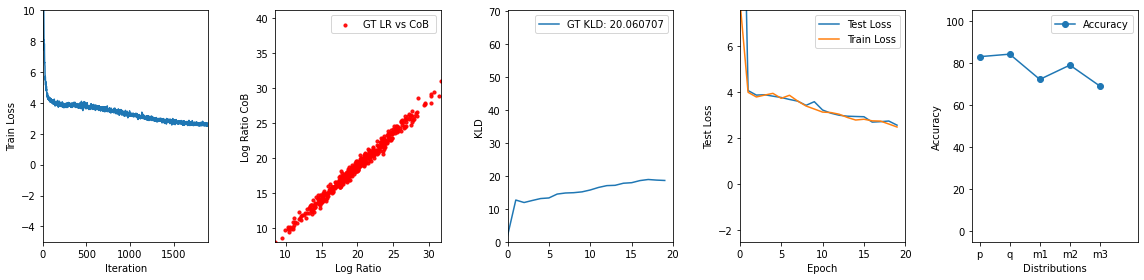

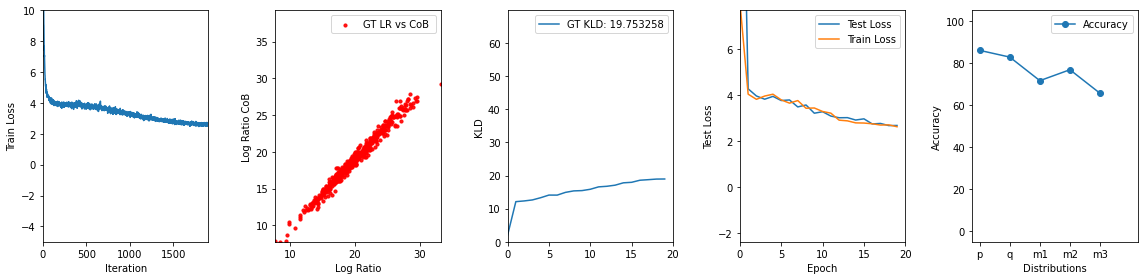

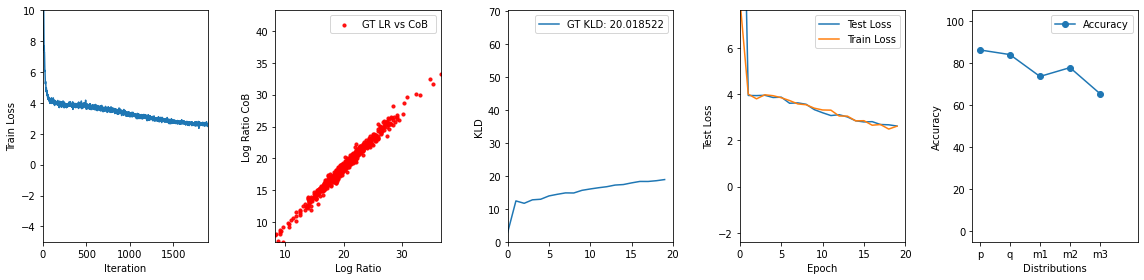

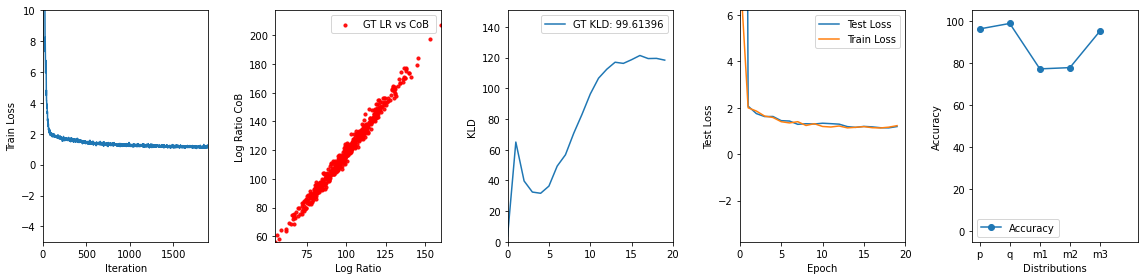

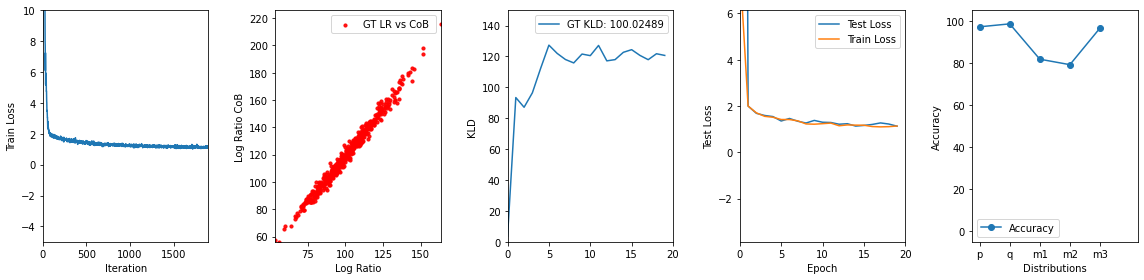

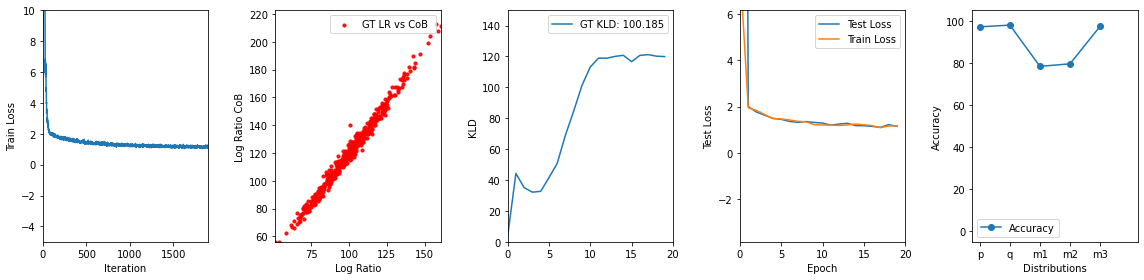

In [46]:
# Config
n_dims = 40
K=5
num_samples=100000
mi = 20
bs=500
N=10
random_means=False
mean_range=[[0,0],[-1.,1.]] #[0,0],[-0.5,0.5],
lrate=5e-2


reset(1)

def get_rho_from_mi(mi, n_dims):
    """Get correlation coefficient from true mutual information"""
    x = (4 * mi) / n_dims
    return (1 - np.exp(-x)) ** 0.5  # correlation coefficient
        
def get_data(mu_1=0.,mu_2=2.,scale_p=0.1,scale_q=0.1,K=5):
    
    p_dist = multivariate_normal(mean=mu_1,cov=scale_p)
    q_dist = multivariate_normal(mean=mu_2,cov=scale_q)
        
    p_samples_ = p_dist.rvs(size=num_samples) 
    q_samples_ = q_dist.rvs(size=num_samples)
    
    if K==5:
        alpha = [0.,0.35,0.5,.85,1.]
        if np.sum(mu_1)==0:
            alpha = [0.,0.25,0.5,.75,1.]
    else:
        alpha = [0.,0.15,0.35,0.5,.75,.95,1.]

    samples=[0]*len(alpha)
    samples[0]=p_samples_
    samples[1]=q_samples_
    for i,a in enumerate(alpha[1:-1]):
        samples[i+2] = np.sqrt(1-a**2)*p_samples_ + a*q_samples_ 
#         samples[i+2] = (1-a)*p_samples_ + a*q_samples_

    p_dist_return = tfd.MultivariateNormalFullCovariance(
        loc=mu_1,
        covariance_matrix=scale_p)
    
    q_dist_return = tfd.MultivariateNormalDiag(
        loc=mu_2,
        scale_diag=scale_q)
    
    return p_dist_return,q_dist_return,samples

def get_params(means,random_means,mi,n_dims):
    
    if random_means==False:
        mu_1=means[0]+np.zeros((n_dims), dtype="float32")
        mu_2=means[1]+np.zeros((n_dims), dtype="float32")
    else:
        mu_1=np.float32(np.random.uniform(low=means[0],high=means[1],size=(n_dims)))
        mu_2=np.float32(np.random.uniform(low=means[0],high=means[1],size=(n_dims)))
   
    rho = get_rho_from_mi(mi, n_dims)  # correlation coefficient
    rhos = np.ones(n_dims // 2, dtype="float32") * rho

    scale_p = block_diag(*[[[1, rho], [rho, 1]] for _ in range(n_dims // 2)])
    scale_p = np.float32(scale_p)
    scale_q = np.ones(n_dims, dtype="float32")
    
    return mu_1,mu_2,scale_p,scale_q

for means in mean_range:
    mu_1,mu_2,scale_p,scale_q = get_params(means,random_means,mi,n_dims)
    
    for run in range(3):
        save_path = '../results/'+str(K)+'--'+str(n_dims)+'--'+str(mi)+'--'+str(random_means)+','+str(means)+'-LR:-'+str(lrate)+'--'+'run_number'+str(run)

        # Check whether the specified path exists or not
        isExist = os.path.exists(save_path)

        if not isExist:
            # Create a new directory because it does not exist 
            os.makedirs(save_path)
            print("The new directory is created!")
            
        if random_means:    
            with open(save_path+'/mu_1.npy', 'wb') as f1:
                np.save(f1, mu_1)
            with open(save_path+'/mu_2.npy', 'wb') as f2:
                np.save(f2, mu_2)
            
        p, q, train_samples = get_data(mu_1,mu_2,scale_p,scale_q,K)
        _, _, test_samples = get_data(mu_1,mu_2,scale_p,scale_q,K)
            
        run_config(save_path,lrate,steps=2000)
    

        gc.collect()
        reset(run)
